In [1]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC


/home/vigrel/Git/ML-project/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [3]:
FILE = "../data/raw/database0002.csv"


def load_data(file_path="../data/raw/database0002.csv") -> pd.DataFrame:
    return pd.read_csv(file_path)


In [4]:
wine = load_data()


<AxesSubplot: >

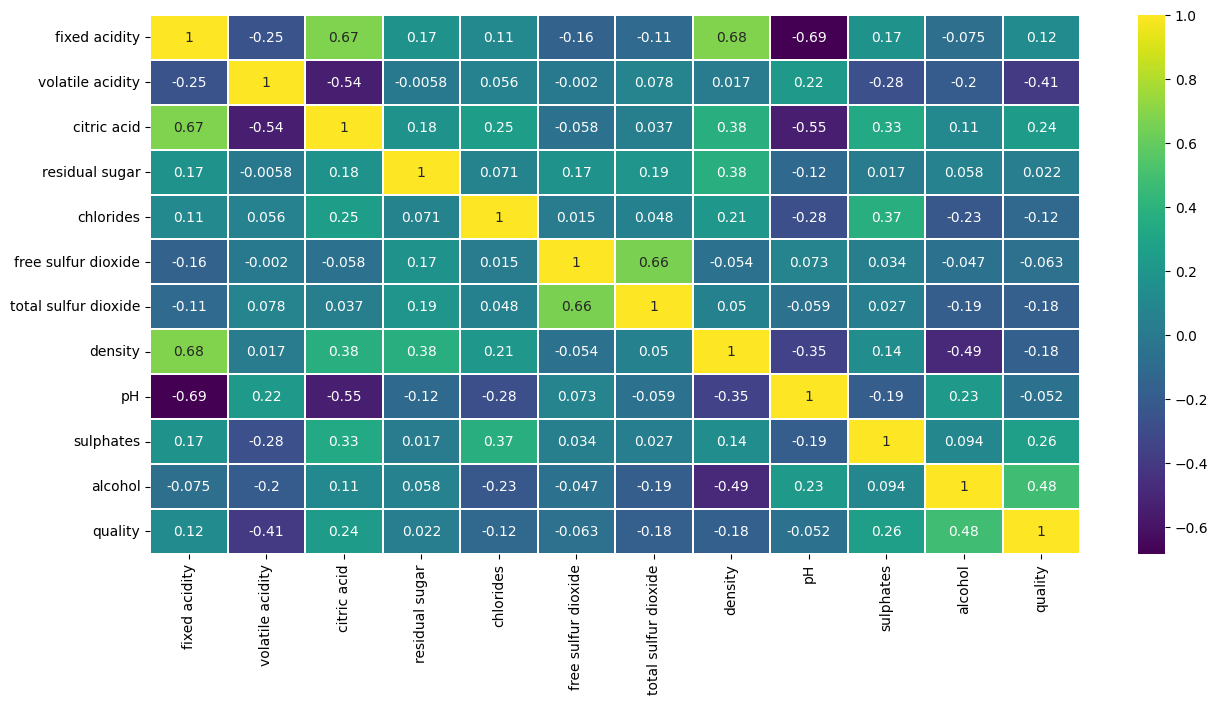

In [5]:
f, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(
    wine.corr(),
    linewidths=0.01,annot=True,cmap="viridis",linecolor="white",xticklabels=wine.columns,yticklabels=wine.columns,)


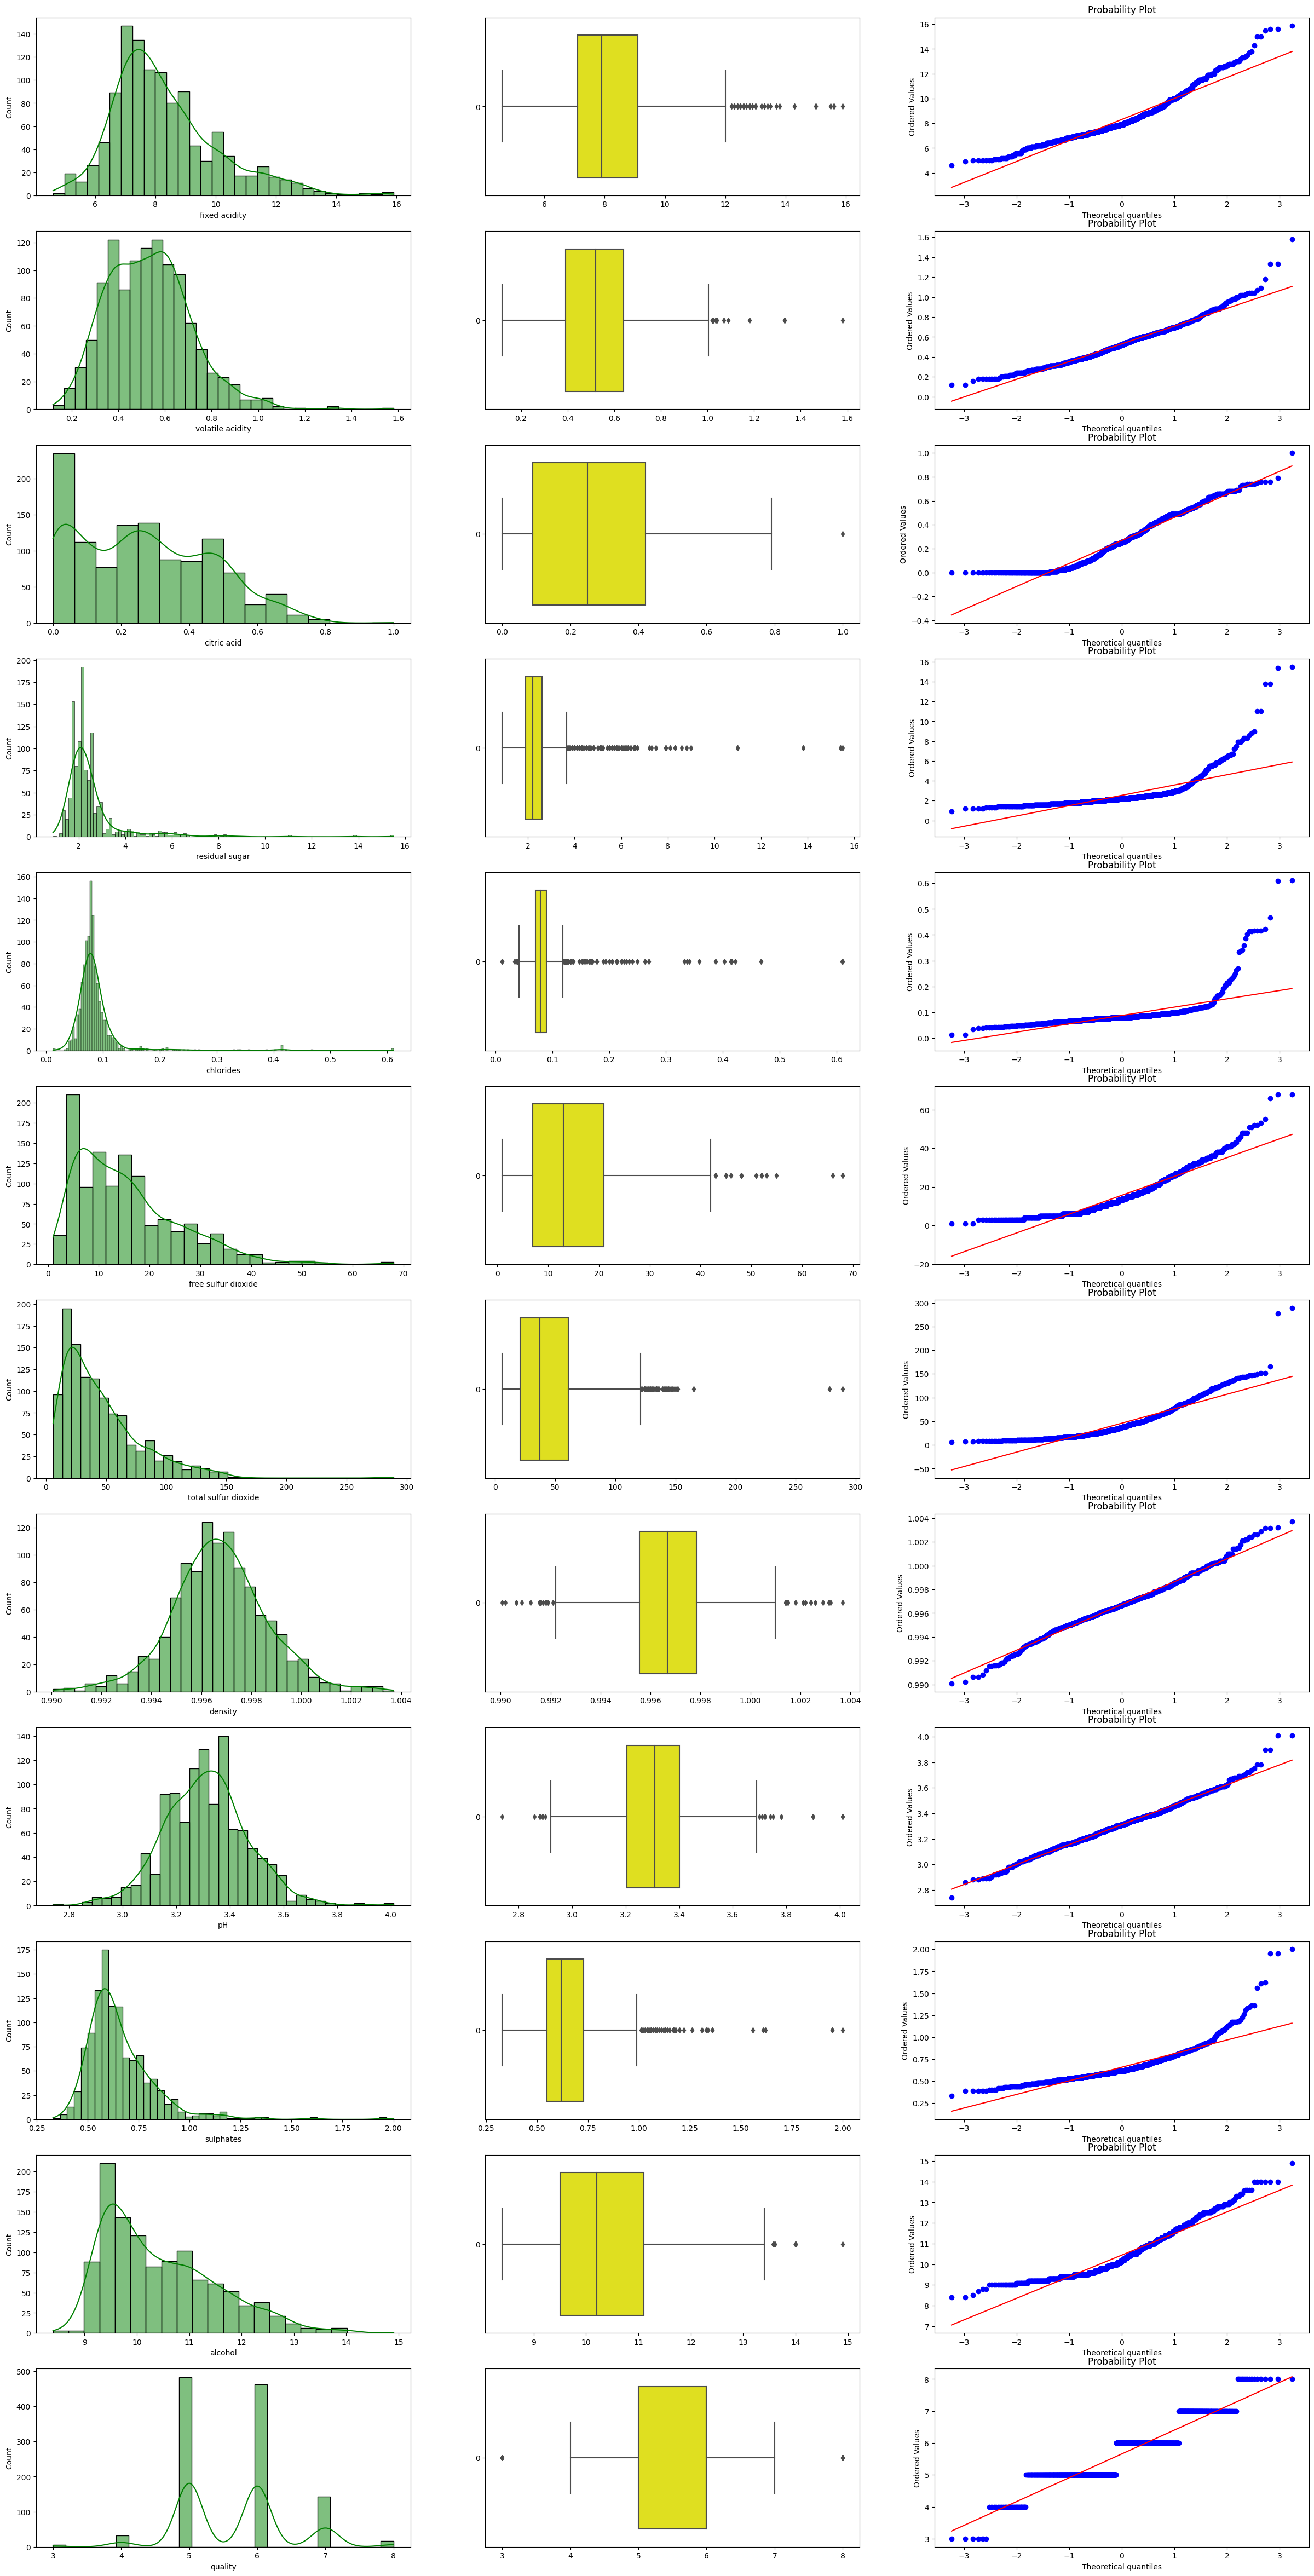

In [6]:
fig,ax = plt.subplots(len(wine.columns),3,figsize=(30,60))
for index,i in enumerate(wine.columns):
    sns.histplot(wine[i],ax=ax[index,0],color='green', kde=True)
    sns.boxplot(wine[i],ax=ax[index,1],color='yellow', orient='h')
    stats.probplot(wine[i],plot=ax[index,2])

# Problemas Foram encontrados em:

### Residual Sugar

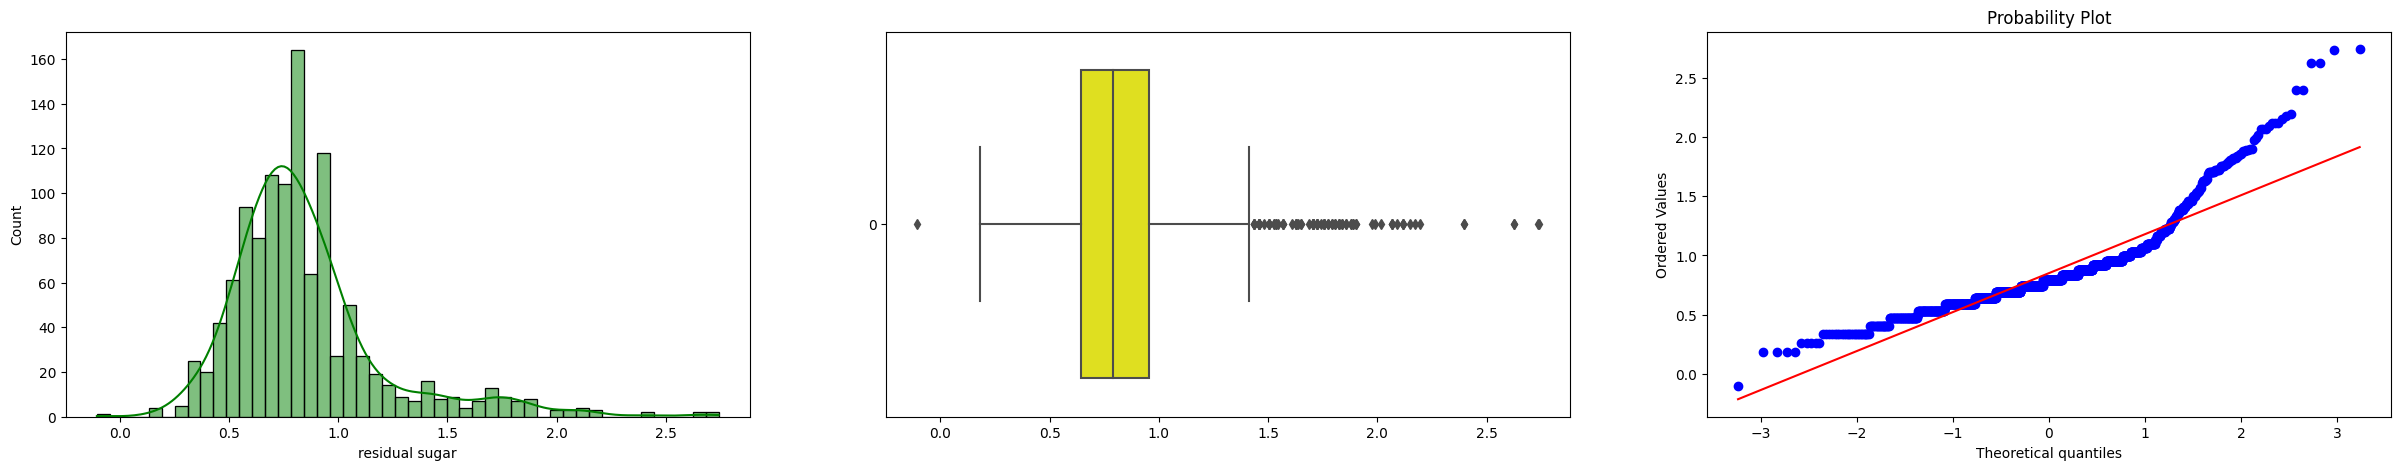

In [7]:
import math

fig,ax = plt.subplots(1,3,figsize=(30,5))
rs = wine['residual sugar']
sns.histplot(rs.apply(np.log), ax=ax[0], color="green", kde=True)
sns.boxplot(rs.apply(np.log), ax=ax[1], color="yellow", orient="h")
stats.probplot(rs.apply(np.log), plot=ax[2])
plt.show()


In [8]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

### free sulfur dioxide

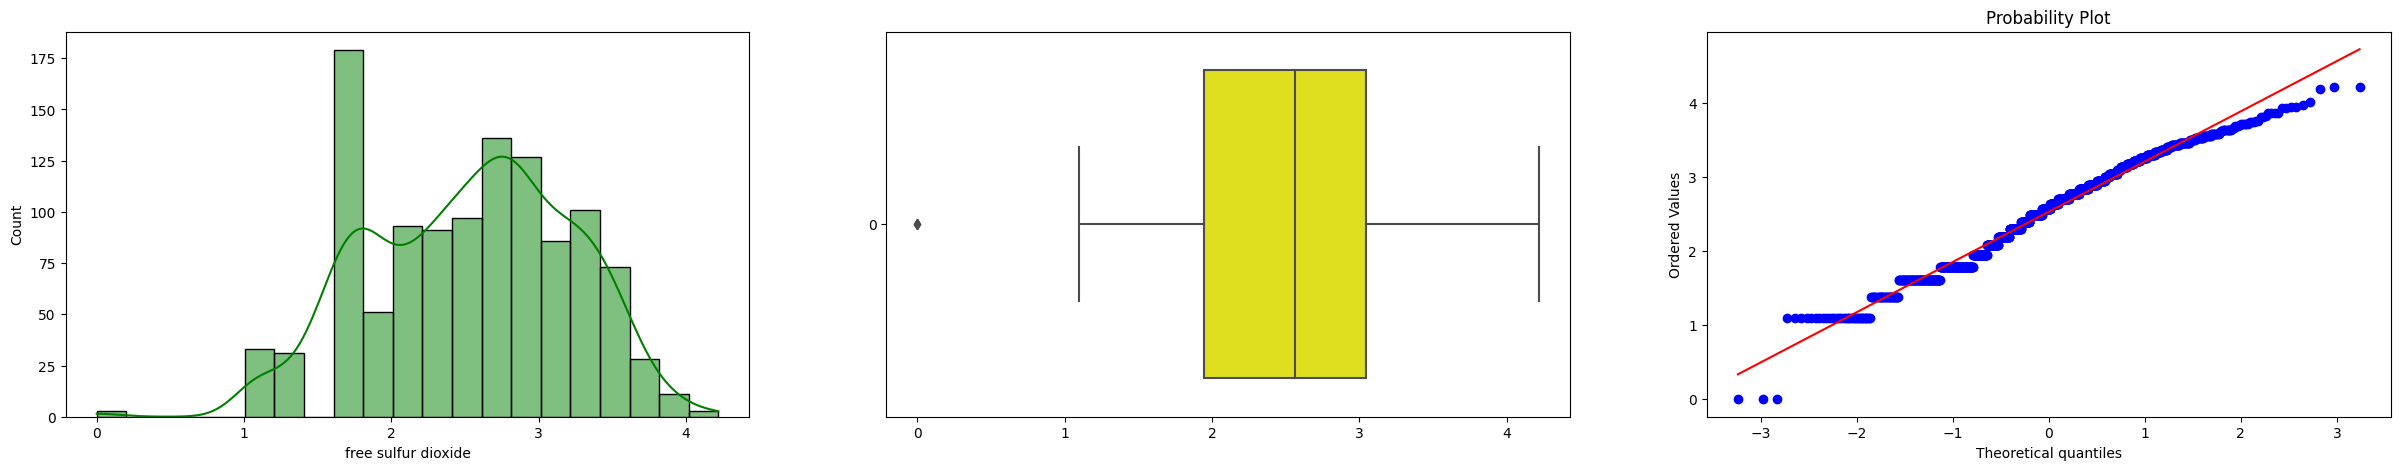

In [9]:
import math

fig,ax = plt.subplots(1,3,figsize=(30,5))
fsd = wine['free sulfur dioxide']
sns.histplot(fsd.apply(np.log), ax=ax[0], color="green", kde=True)
sns.boxplot(fsd.apply(np.log), ax=ax[1], color="yellow", orient="h")
stats.probplot(fsd.apply(np.log), plot=ax[2])
plt.show()


### sulphates

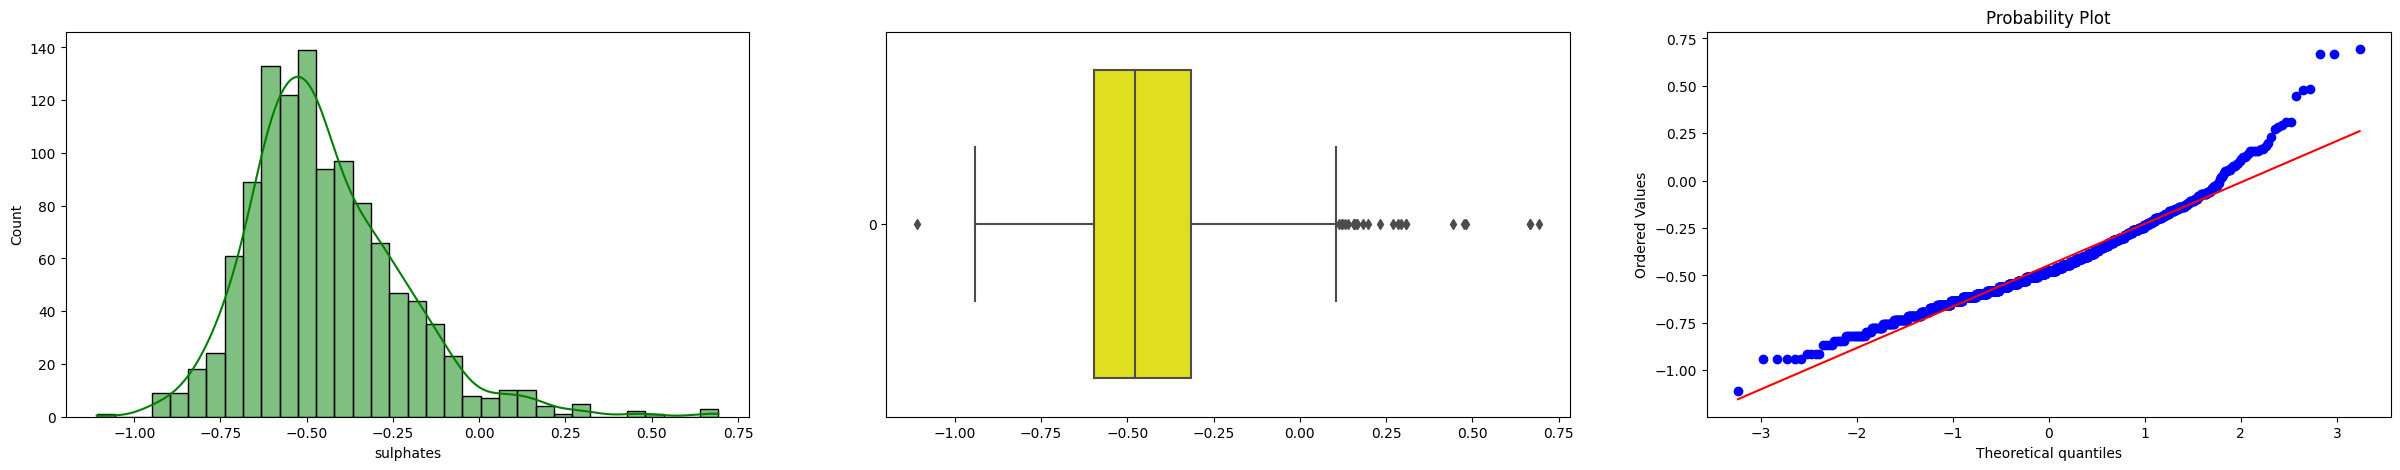

In [10]:
import math

fig,ax = plt.subplots(1,3,figsize=(30,5))
sp = wine['sulphates']
sns.histplot(sp.apply(np.log), ax=ax[0], color="green", kde=True)
sns.boxplot(sp.apply(np.log), ax=ax[1], color="yellow", orient="h")
stats.probplot(sp.apply(np.log), plot=ax[2])
plt.show()


### chlorides

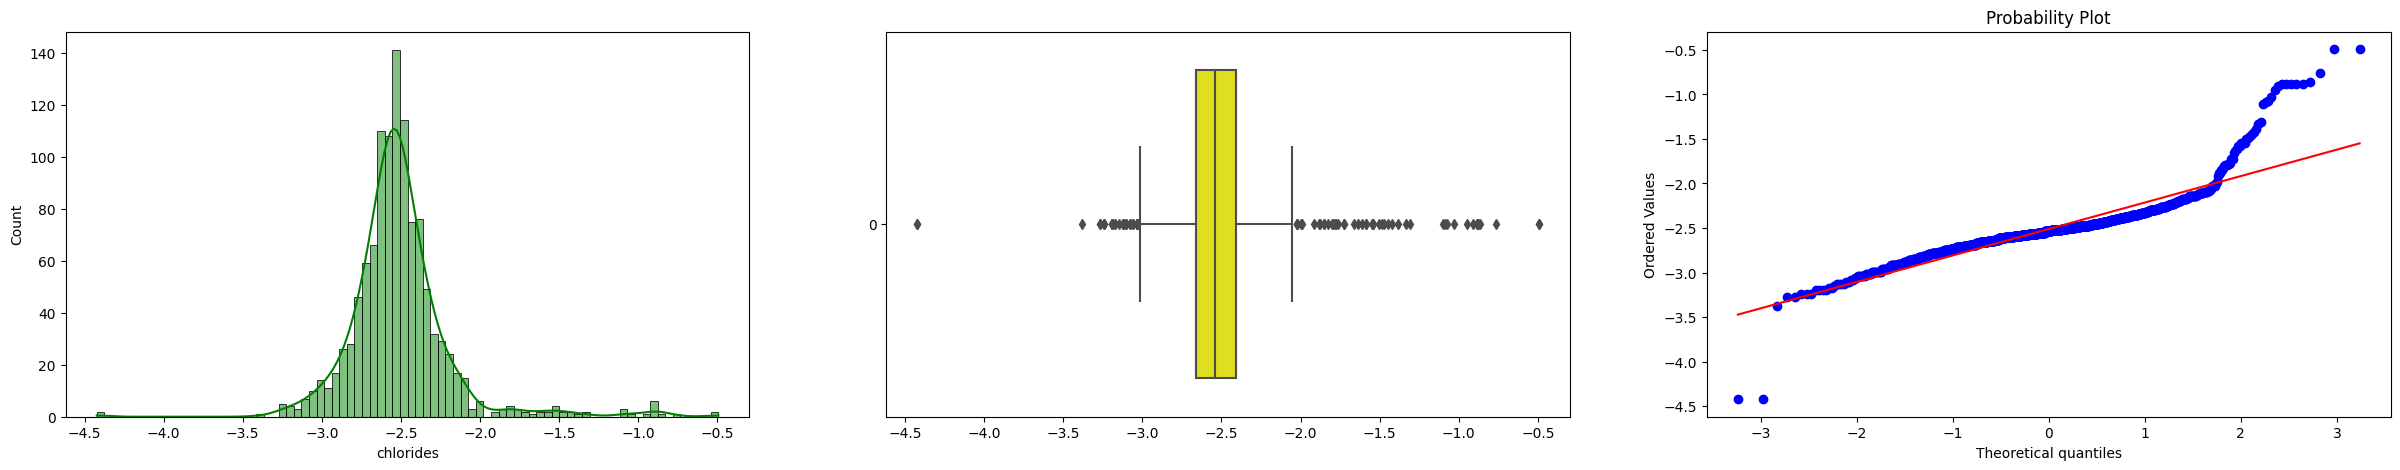

In [11]:
import math

fig,ax = plt.subplots(1,3,figsize=(30,5))
ch = wine['chlorides']
sns.histplot(ch.apply(np.log), ax=ax[0], color="green", kde=True)
sns.boxplot(ch.apply(np.log), ax=ax[1], color="yellow", orient="h")
stats.probplot(ch.apply(np.log), plot=ax[2])
plt.show()


# Stratificação

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42,
)
for train_index, test_index in split.split(wine, wine["quality"]):
    train_set = wine.loc[train_index]
    test_set = wine.loc[test_index]


# Pipeline0002

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

tsd, chl, rs, sp = [
    wine.columns.get_loc(i)
    for i in ["total sulfur dioxide", "chlorides", "residual sugar", "sulphates"]
]

class LogAtt(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X[~(X[:,-1] == 3),:]
        X = X[~(X[:,-1] == 8),:]

        X_l = X
        X_l[:, tsd] = np.log(X[:, tsd])
        X_l[:, chl] = np.log(X[:, chl])
        X_l[:, rs] = np.log(X[:, rs])
        X_l[:, sp] = np.log(X[:, sp])
        
        return X_l[:, :-1], X_l[:, -1]

pipe = LogAtt()


# Testando modelos de forma superficial

In [14]:
X_train_pp, Y_train_pp = pipe.transform(train_set.values)
X_test_pp, Y_test_pp = pipe.transform(test_set.values)
CROSS_VAL = 5


In [15]:
svc_clf = SVC(random_state=RANDOM_SEED)
svc_clf.fit(X_train_pp, Y_train_pp)
svc_clf_pred = cross_val_predict(svc_clf, X_train_pp, Y_train_pp, cv=CROSS_VAL)

confusion_matrix(Y_train_pp, svc_clf_pred), accuracy_score(Y_train_pp, svc_clf_pred)


(array([[  0,  16,  10,   0],
        [  0, 328,  58,   0],
        [  0, 217, 153,   0],
        [  0,  18,  96,   0]]),
 0.5368303571428571)

In [16]:
sgd_clf = SGDClassifier(random_state=RANDOM_SEED)
sgd_clf.fit(X_train_pp, Y_train_pp)
sgd_clf_pred = cross_val_predict(sgd_clf, X_train_pp, Y_train_pp, cv=CROSS_VAL)

confusion_matrix(Y_train_pp, sgd_clf_pred), accuracy_score(Y_train_pp, sgd_clf_pred)


(array([[  1,  16,   9,   0],
        [  7, 262, 111,   6],
        [  6, 206, 131,  27],
        [  2,  32,  53,  27]]),
 0.46986607142857145)

In [17]:
rf_clf = RandomForestClassifier(random_state=RANDOM_SEED)
rf_clf.fit(X_train_pp, Y_train_pp)
rf_clf_pred = cross_val_predict(rf_clf, X_train_pp, Y_train_pp, cv=CROSS_VAL)

confusion_matrix(
    Y_train_pp,
    rf_clf_pred,
), accuracy_score(Y_train_pp, rf_clf_pred)


(array([[  0,  18,   8,   0],
        [  1, 287,  93,   5],
        [  1,  88, 248,  33],
        [  0,   8,  52,  54]]),
 0.6573660714285714)

# Tuning hyperparameters

In [18]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "criterion": trial.suggest_categorical("criterion", ['gini', 'entropy']),
        "max_depth": trial.suggest_int("max_depth", 2, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 10)
    }

    rf = RandomForestClassifier(**param)

    rf.fit(X_train_pp, Y_train_pp)

    preds = rf.predict(X_test_pp)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(Y_test_pp, pred_labels)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-11-21 15:27:16,946] A new study created in memory with name: no-name-e810c66e-c362-4c52-a4f9-cd7eafabf3fa
[I 2022-11-21 15:27:17,130] Trial 0 finished with value: 0.6933333333333334 and parameters: {'n_estimators': 98, 'criterion': 'gini', 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.6933333333333334.
[I 2022-11-21 15:27:18,865] Trial 1 finished with value: 0.7022222222222222 and parameters: {'n_estimators': 787, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.7022222222222222.
[I 2022-11-21 15:27:20,319] Trial 2 finished with value: 0.6755555555555556 and parameters: {'n_estimators': 993, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.7022222222222222.
[I 2022-11-21 15:27:21,965] Trial 3 finished with value: 0.6755555555555556 and parameters: {'n_estimators': 940, 'criterion': 'gini', 'max_d

Number of finished trials: 100
Best trial:
  Value: 0.7244444444444444
  Params: 
    n_estimators: 868
    criterion: entropy
    max_depth: 19
    min_samples_split: 2
    min_samples_leaf: 2


In [19]:
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))
hist = study.trials_dataframe()
hist.tail(5)

Best trial: score 0.7244444444444444,
params {'n_estimators': 868, 'criterion': 'entropy', 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2}


,number,value,datetime_start,datetime_complete,duration,params_criterion,params_max_depth,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state
95,95,0.702222,2022-11-21 15:29:25.049575,2022-11-21 15:29:26.355258,0 days 00:00:01.305683,entropy,29,2,4,526,COMPLETE
96,96,0.680000,2022-11-21 15:29:26.356185,2022-11-21 15:29:27.221721,0 days 00:00:00.865536,gini,24,7,4,419,COMPLETE
97,97,0.688889,2022-11-21 15:29:27.223049,2022-11-21 15:29:28.013484,0 days 00:00:00.790435,gini,17,5,5,379,COMPLETE
98,98,0.711111,2022-11-21 15:29:28.014318,2022-11-21 15:29:28.628499,0 days 00:00:00.614181,gini,10,2,4,309,COMPLETE
99,99,0.684444,2022-11-21 15:29:28.629328,2022-11-21 15:29:28.963441,0 days 00:00:00.334113,gini,10,3,3,168,COMPLETE
